<a href="https://colab.research.google.com/github/cheryltky/kaggle/blob/main/Application_Fastai_chapter1_chestxraydataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount onto google drive, make a folder for chest xray files

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cheryltky","key":"e38a85540325a02a75ec95bedb709165"}'}

In [5]:
mkdir -p /content/kaggle/

In [4]:
mkdir -p /content/kaggle/data

In [6]:
mkdir -p /content/kaggle/data/model

In [7]:
!pwd [-LP]

/content


In [8]:
#move the downloaded kaggle.json file to the newly created kaggle folder
!mv /content/kaggle.json /content/kaggle/kaggle.json 

In [9]:
!chmod 600 /content/kaggle/kaggle.json

In [10]:
# Import OS for navigation and environment set up
import os
# Check current location, '/content' is the Colab virtual machine
os.getcwd()
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = '/content/kaggle'

Download the kaggle dataset via kaggle API

In [ ]:
#!kaggle datasets list

In [11]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 20.2MB/s]
100% 2.29G/2.29G [00:30<00:00, 81.3MB/s]


In [12]:
mv /content/chest-xray-pneumonia.zip /content/kaggle/data/

In [13]:
%cd /content/kaggle/data

/content/kaggle/data


In [14]:
!sudo apt-get install unzip
!unzip /content/kaggle/data/*.zip 

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [15]:
os.chdir('/content/kaggle/data')
#or this: changing the working directory
# %cd /content/kaggle/data

In [16]:
os.listdir()

['chest-xray-pneumonia.zip', 'model', 'chest_xray']

In [17]:
# remove duplicate data files
!rm -rf /content/kaggle/data/chest_xray/__MACOSX
!rm -rf /content/kaggle/data/chest_xray/chest_xray

Install relevant packages for fastai 

In [8]:
!pip install fastai --upgrade 
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

Requirement already up-to-date: fastai in /usr/local/lib/python3.7/dist-packages (2.3.1)
Mounted at /content/gdrive


In [5]:
from fastai.vision import *
from fastai.imports import *

In [12]:
root_path = Path('/')
data_path = Path('/content/kaggle/data/chest_xray').absolute()
model_path = Path ('/content/kaggle/data/model').absolute()

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [13]:

sz = 256
lr = defaults.lr
bs = 64
stats = ([0.48746821, 0.48746821, 0.48746821], [0.24557937, 0.24557937, 0.24557937])

In [14]:
def valid_func(o: Path):
    return 'test' in str(o)

def label_func(o: Path):
    if 'virus' in o.name:
        return 'pneumonia'
    if 'bacteria' in o.name:
        return 'pneumonia'
    return 'normal'

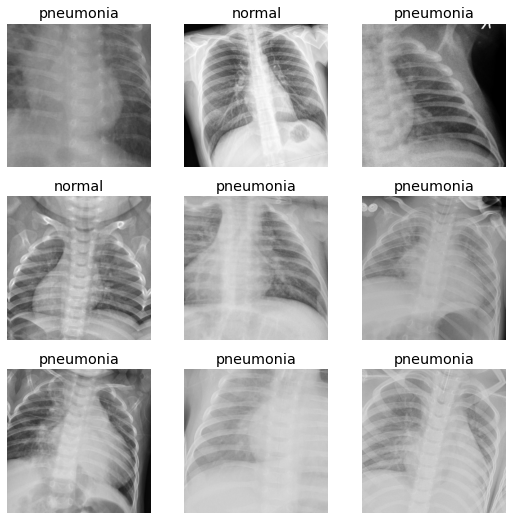

In [16]:

db = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=FuncSplitter(valid_func),
                 get_y=label_func,
                 item_tfms=Resize(sz*2),
                 batch_tfms=[*aug_transforms(size=sz), Normalize.from_stats(*stats)])

data = db.dataloaders(data_path)
data.show_batch(max_n=9)

In [ ]:
learn = cnn_learner(data,
                    resnet50,
                    metrics=error_rate,
                    bn_wd=False,
                    loss_func=LabelSmoothingCrossEntropy(),
                    cbs=[BnFreeze,
                          SaveModelCallback(monitor='error_rate', name='best_error'),
                          ShowGraphCallback,
                         ],
                    model_dir=model_path,
                   ).to_fp16()

In [ ]:
data = ImageDataBunch.from_folder(data_path,
                                  valid_pct=0.2,
                                  size= 256, 
                                  ds_tfms=get_transforms()
                                  ).normalize(imagenet_stats)

In [ ]:
print(data.classes, len(data.train_ds), len(data.valid_ds))

['NORMAL', 'PNEUMONIA'] 4685 1171


In [19]:
# create 'learner' to learn from the dataset
# learner learns from your trained dataset
learn = cnn_learner(data,
                    resnet50,
                    metrics=error_rate,
                    model_dir=model_path)



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [30]:
def train(learn, name, lr, n_epochs=5, **kwargs): # must be called kwargs, not kw_args or anything else
    learn.fit_one_cycle(n_epochs, lr, **kwargs)
    learn.save(name)

In [31]:
train(learn, 'stage_1', lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.170398,0.653983,0.150641,01:59
1,0.139170,0.453888,0.161859,02:01
2,0.102866,0.334520,0.102564,02:01
3,0.077768,0.331485,0.083333,02:00
4,0.060283,0.375514,0.110577,02:00


In [20]:
# learn.fit_one_cycle(5)


epoch,train_loss,valid_loss,error_rate,time
0,0.396447,0.606517,0.128205,01:55
1,0.234989,0.533423,0.134615,01:55
2,0.140716,0.402767,0.118590,01:56
3,0.106940,0.377955,0.107372,01:55
4,0.092713,0.410155,0.131410,01:55


In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:

lr = 3e-4
train(learn, 'stage_2', slice(lr/100, lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.042130,0.440817,0.115385,02:00


In [ ]:
learn.lr_find() # learning rate is the most important hyperparameter for a DL system

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
learn.recorder.plot()
#shows the effect of different learning rates, if learning rate is too high, your loss shoots up

In [ ]:
learn.fit_one_cycle(5, max_lr=3e-4)
#second stage to tune the hyperparamteter
#final epoch error rate is now 1.7%
# beware of overfitting: training loss is going down, valid loss is going up

In [ ]:
learn.export(model_path / 'pneumonia.pkl')
learn.save(model_path / 'pneumonia')

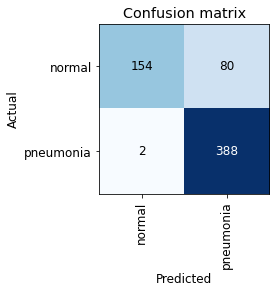

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [ ]:
# def get_num_images(file_path, form='total'):
#     """ Follows a filepath for this dataset and counts the images per class of NORMAL or PNEUMONIA X-rays.
#         Option to return the 'total' elements per folder or a 'tuple' of the count for each type,
#         or the 'normed' count (percentage per class of total).

#         Output format: (NORMAL, PNEUMONIA) """    

#     # Calculate quantities
#     normal = len(os.listdir(file_path + '/NORMAL'))
#     pneum = len(os.listdir(file_path + '/PNEUMONIA'))
#     tot = normal + pneum

#     # Format return type
#     if form == 'total':
#         return tot
#     if form == 'normed':
#         return tuple(round(i, 3) for i in ((normal/tot), (pneum/tot)))
#     if form == 'tuple':
#         return (normal, pneum) 

In [ ]:
# # Connect to Data
# project_path = '/content/kaggle/data'

# #Establish file paths for each of the unzipped data folders on the virtual machine
# train_path = '/content/kaggle/data/chest_xray/train'
# test_path = '/content/kaggle/data/chest_xray/test'
# val_path = '/content/kaggle/data/chest_xray/val'

# #count images per path
# [get_num_images(path, form='total') for path in [train_path, test_path, val_path]]

In [ ]:

# # Quick examination of the class distribution for each set as items and then percentage split
# # Tuple presented as (Normal, Pneumonia)
# display([x.split('/')[-1] for x in [train_path, test_path, val_path]])
# display([get_num_images(path, form='tuple') for path in [train_path, test_path, val_path]])
# [get_num_images(path, form='normed') for path in [train_path, test_path, val_path]]